In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from cycle_detection import detect_respiration_cycles
from deform_tools import deform_to_cycle_template
from respiration_features import get_all_respiration_features
import tqdm
from params import * 
import ghibtools as gt
%matplotlib inline

## LOAD 

In [3]:
stretch = False

In [4]:
input_file = f'../dataarray/da_staged_{patient}.nc'

In [5]:
da = xr.load_dataarray(input_file)#.dropna(dim='time').sel(stage = stage_to_study)

In [6]:
da = da.loc[stage_to_study,:,:].dropna(dim='time')
da

<xarray.DataArray (chan: 30, time: 3202560)>
array([[ 9.97961028e+01,  9.78245223e+01,  9.58710408e+01, ...,
         2.17710750e+02,  2.17343681e+02,  2.16662896e+02],
       [ 5.72698123e+01,  5.90547941e+01,  5.96600247e+01, ...,
        -4.67884969e+01, -4.80349721e+01, -4.87314812e+01],
       [-2.88983473e+01, -2.83513051e+01, -2.56071060e+01, ...,
        -3.31188722e+01, -3.46614456e+01, -3.59299381e+01],
       ...,
       [ 1.90737774e-02,  1.90737774e-02,  1.90737774e-02, ...,
         1.90737774e-02,  1.90737774e-02,  1.90737774e-02],
       [-1.24677295e+00, -1.24899475e+00, -1.24874837e+00, ...,
        -1.26089603e+00, -1.26011111e+00, -1.26042198e+00],
       [ 1.92609507e+00,  1.95678999e+00,  1.96588313e+00, ...,
         1.59122326e+00,  1.58592375e+00,  1.66119214e+00]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 1.251e+04 1.251e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'CPAP' 'PRESSION' '-'
    stage    <U2 'N2'

## PARAMS

In [7]:
chans = list(da.coords['chan'].values)

In [8]:
save = True

In [9]:
save_presentation = False

## TOOLS

In [10]:
def stretch_data(resp_features, nb_point_by_cycle, data, srate):

    # params
    cycle_times = resp_features[['inspi_time', 'expi_time']].values
    mean_cycle_duration = np.mean(resp_features[['insp_duration', 'exp_duration']].values, axis=0)
    mean_inspi_ratio = mean_cycle_duration[0]/mean_cycle_duration.sum()
    times = np.arange(0,np.size(data))/srate

    clipped_times, times_to_cycles, cycles, cycle_points, data_stretch_linear = deform_to_cycle_template(
            data, times, cycle_times, nb_point_by_cycle=nb_point_by_cycle, inspi_ratio=0.4)

    nb_cycle = data_stretch_linear.shape[0]//nb_point_by_cycle
    phase = np.arange(nb_point_by_cycle)/nb_point_by_cycle
    data_stretch = data_stretch_linear.reshape(int(nb_cycle), int(nb_point_by_cycle))

    return data_stretch

In [11]:
def plot_cycle_points(resp, cycles, t , srate=srate, save_presentation=save_presentation, rsp_chan=rsp_chan[patient]):
    plt.figure()
    plt.plot(resp_sig)
    plt.plot(cycles[:,0], resp_sig[cycles[:,0]], 'o', color = 'b')
    plt.plot(cycles[:,1], resp_sig[cycles[:,1]], 'o', color = 'r')
    plt.xlim(t[0]*srate, t[1]*srate)
    # plt.ylim(-20,20)
    plt.title(f'Resp signal from {rsp_chan} : cycle detection')
    if save_presentation:
        plt.savefig('../presentation/rsp_cycle_detection')
    plt.show()

## DATA SEL

In [12]:
resp_sig = da.loc[rsp_chan[patient],:].values
da_eeg = da.loc[eeg_chans,:]

## CYCLE DETECTION

In [13]:
cycles = detect_respiration_cycles(resp_sig, sampling_rate=srate, t_start = 0., output = 'index',

                                    # preprocessing
                                    inspiration_sign = rsp_detect_sign[patient],
                                    high_pass_filter = None,
                                    constrain_frequency = None,
                                    median_windows_filter = None,
                                    
                                    # baseline
                                    baseline_with_average = True,
                                    manual_baseline = 0.,
                                    
                                    # clean
                                    eliminate_time_shortest_ratio = 2,
                                    eliminate_amplitude_shortest_ratio = 10,
                                    eliminate_mode = 'OR', # 'AND'
                                    
                                    )

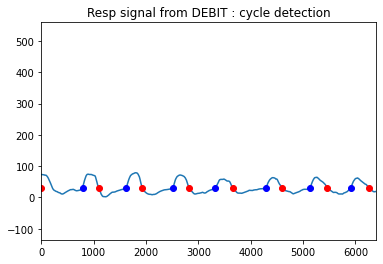

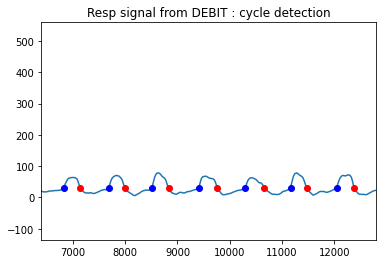

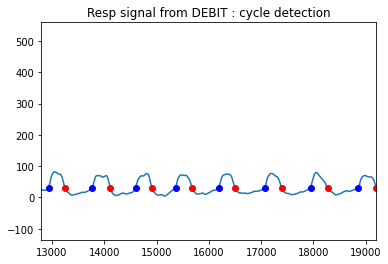

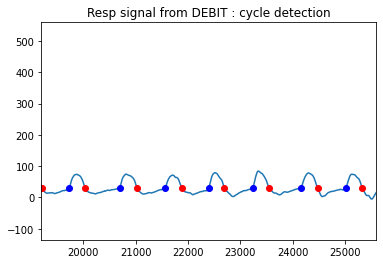

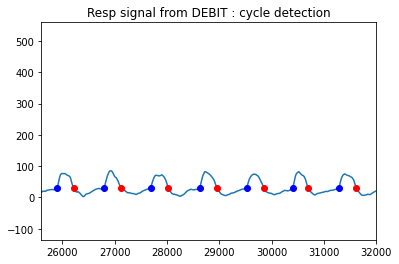

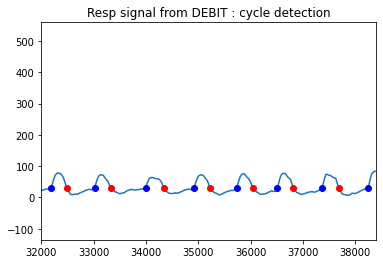

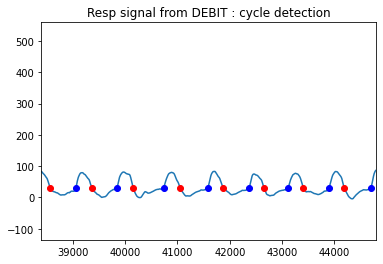

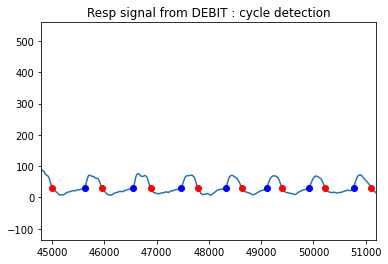

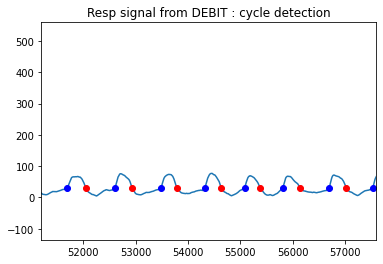

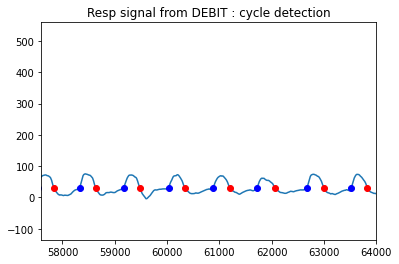

In [14]:
for start in range(0,250,25):
    plot_cycle_points(resp=resp_sig, cycles=cycles, t=(start,start+25))

## RESP FEATURES FROM CYCLES & RESP

In [15]:
resp_features = get_all_respiration_features(resp_sig=resp_sig, sampling_rate=srate, cycles=cycles, t_start = 0.)

/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'objec

In [16]:
resp_features

,cycle_num,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,cycle_freq,insp_volume,exp_volume,total_amplitude,insp_amplitude,exp_amplitude
0,0,785,1094,3.066406,4.273438,3.261719,1.207031,2.054688,0.306587,75.578262,33.057099,105.152835,74.332829,30.820007
1,1,1620,1928,6.328125,7.531250,3.492188,1.203125,2.289062,0.286353,76.835075,42.169506,109.701751,78.890869,30.810881
2,2,2514,2819,9.820312,11.011719,3.171875,1.191406,1.980469,0.315271,70.971651,36.468734,102.698581,71.720908,30.977672
3,3,3326,3656,12.992188,14.281250,3.781250,1.289062,2.492188,0.264463,64.387070,54.198590,89.459961,58.642074,30.817887
4,4,4294,4605,16.773438,17.988281,3.281250,1.214844,2.066406,0.304762,62.556225,43.092214,94.183617,63.223691,30.959926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,2479,2667652,2667946,10420.515625,10421.664062,3.203125,1.148438,2.054688,0.312195,75.145265,21.572221,119.843260,88.822067,31.021193
2480,2480,2668472,2668778,10423.718750,10424.914062,3.359375,1.195312,2.164062,0.297674,80.619820,24.688152,119.738339,88.812426,30.925913
2481,2481,2669332,2669622,10427.078125,10428.210938,3.222656,1.132812,2.089844,0.310303,81.099905,21.762505,124.489762,93.702418,30.787344
2482,2482,2670157,2670444,10430.300781,10431.421875,3.207031,1.121094,2.085938,0.311815,78.449569,30.743478,125.432018,94.618876,30.813142


In [17]:
resp_features[['cycle_duration','insp_duration','exp_duration','cycle_freq']].mean()

cycle_duration    4.200316
insp_duration     1.213641
exp_duration      2.986676
cycle_freq        0.304107
dtype: float64

## STRETCHING NEURO DATA TO RESP CYCLES

In [18]:
if stretch:
    da_stretched = None
    for chan in eeg_chans:
        print(chan)
        data_stretch = stretch_data(resp_features=resp_features, nb_point_by_cycle=1000, data=da.loc[chan,:].values, srate=srate)
        if da_stretched is None:
            da_stretched = gt.init_da({'chan':eeg_chans, 'cycle':np.arange(0,data_stretch.shape[0],1), 'point':np.arange(0,data_stretch.shape[1],1)})
        da_stretched.loc[chan, : , :] = data_stretch

In [19]:
if save:
    resp_features.to_excel(f'../df_analyse/resp_features_{patient}.xlsx')
    if stretch:
        da_stretched.to_netcdf(f'../dataarray/da_neuro_stretched_{patient}.nc')

In [20]:
if stretch:
    da_stretched

In [21]:
if stretch:
    da_stretched.loc['Fp2-C4',:,:].plot.pcolormesh(x='point')

In [22]:
if stretch:
    for chan in eeg_chans:
        plt.figure()
        da_stretched.loc[chan,:,:].mean('cycle').plot.line(x='point')
        plt.show()